Basic imports

In [1]:
from papyrus_scripts.reader import read_papyrus
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np
import pandas as pd

Loading data from papyrus through papyrus_scripts

In [3]:
data = read_papyrus(is3d=False, source_path=None)

Selecting targets with over min_number_of_mol assigned molecules

In [205]:
min_number_of_mol = 1000
groups_by_target = data.groupby(by="target_id")
targets_count = groups_by_target.count()['Activity_ID']
targets = targets_count[targets_count > min_number_of_mol].sort_values(ascending=False)
targets = targets.reset_index()
targets.rename(columns={'Activity_ID': 'size'}, inplace=True)

Counting all available descriptors

In [208]:
precalculated_descriptor_loc = './data/data_with_descriptors.csv'

all_descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
get_descriptors = rdMolDescriptors.Properties(all_descriptor_names)

def smiles_to_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    descriptors_ = []
    if mol:
        descriptors_ = np.array(get_descriptors.ComputeProperties(mol))
    return descriptors_


try:
    with open(precalculated_descriptor_loc) as file:
        data = pd.read_csv(file, index_col=0)
except:
    print('Precalculated descriptors not found.\nCalculating\nThis will take some time')
    descriptors = pd.DataFrame((data.SMILES.apply(smiles_to_descriptors)).to_list(), columns=all_descriptor_names)
    data = pd.concat([data, descriptors], axis=1)

    print('Descriptors calculated saving to ' + precalculated_descriptor_loc)
    data = data.to_csv(precalculated_descriptor_loc)

Scaling descriptors value

In [241]:
from sklearn.preprocessing import MinMaxScaler

descriptors_scaled = data[all_descriptor_names]
scaler = MinMaxScaler()
descriptors_scaled = pd.DataFrame(scaler.fit_transform(descriptors_scaled), columns=descriptors_scaled.columns)
data_scaled = pd.concat([descriptors_scaled, data[['SMILES', 'target_id']]], axis=1)

Which descriptors can't be used in calculating cover of chemical space

In [210]:
groups_by_target = data_scaled.groupby(by="target_id")
descriptor_dict = {}

def get_group(target):
    if isinstance(target, int):
        return (groups_by_target.get_group(targets['target_id'][target])).reset_index().drop(columns=['index'])
    return (groups_by_target.get_group(target)).reset_index().drop(columns=['index'])


for i in range(targets.shape[0]):
    target = targets['target_id'][i]
    describe = get_group(target).describe()
    desc_names = list(describe.transpose()[np.array((describe.transpose()['75%'] - describe.transpose()['25%']) == 0)].index)
    descriptor_dict[target] = desc_names

Visualization no obvious dependence between number of molecules in a group and number of unusable descriptors

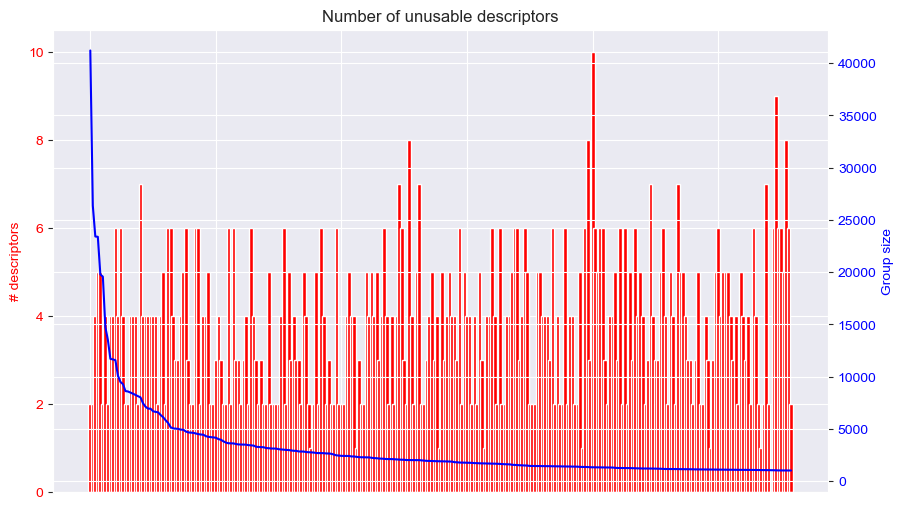

In [211]:
import matplotlib.pyplot as plt

group_len = []
desc_len = []

for target in descriptor_dict:
    desc_len.append(len(descriptor_dict[target]))
    group_len .append(get_group(target).shape[0])

x = np.arange(0, targets.shape[0], 1)

fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax1.set_ylabel('# descriptors', color = 'red')
ax1.bar(x, desc_len, color = 'red', width=1.5)
ax1.tick_params(axis ='y', labelcolor = 'red')
ax1.set_title('Number of unusable descriptors')

ax2 = ax1.twinx()
ax2.set_ylabel('Group size', color = 'blue')
ax2.plot(x, group_len, color = 'blue')
ax2.tick_params(axis ='y', labelcolor = 'blue')

plt.show()

In [212]:
unused_descriptors = set()
unused_targets = []

for key in descriptor_dict:
    if len(descriptor_dict[key]) > 7:
        unused_targets.append(key)
    else:
        unused_descriptors.update(descriptor_dict[key])

print("Print unused targets: " + str(unused_targets))
print("Unused descriptors: " + str(unused_descriptors) + "\nCount: " + str(len(unused_descriptors)))

Print unused targets: ['Q07869_WT', 'Q03181_WT', 'P31639_WT', 'P80457_WT', 'P34976_WT']
Unused descriptors: {'NumSaturatedHeterocycles', 'NumAromaticRings', 'NumBridgeheadAtoms', 'NumHBD', 'NumSpiroAtoms', 'lipinskiHBD', 'NumAtomStereoCenters', 'NumAromaticHeterocycles', 'NumUnspecifiedAtomStereoCenters', 'NumAliphaticRings', 'NumAliphaticHeterocycles', 'NumRings', 'NumAmideBonds', 'NumSaturatedRings'}
Count: 14


Not using descriptors
 - lipinskiHBA/HBD -> using more general version NumHBA/HBD
 - amw -> using more general version exactmw
 - chi[0-4][v/n] -> hard to explain descriptors
 - kappa[1-3] -> same as above
 - NumAtoms, NumHeavyAtoms, NumHeteroAtoms -> using more general descriptor exactmw
 - labuteASA, CrippenMR, Phi -> great correlation with exactmw
 - all from unused descriptors set -> Not usable in later analysis

,exactmw,NumRotatableBonds,NumHBA,FractionCSP3,NumHeterocycles,tpsa,CrippenClogP,hallKierAlpha
exactmw,1.000000,0.647132,0.541826,0.205092,0.271007,0.527697,0.403933,-0.593963
NumRotatableBonds,0.647132,1.000000,0.363262,0.323603,-0.108527,0.415503,0.217116,-0.336307
NumHBA,0.541826,0.363262,1.000000,0.088657,0.488721,0.736937,-0.210773,-0.482556
FractionCSP3,0.205092,0.323603,0.088657,1.000000,0.082129,0.010772,-0.109425,0.360933
NumHeterocycles,0.271007,-0.108527,0.488721,0.082129,1.000000,0.150781,-0.008207,-0.284904
tpsa,0.527697,0.415503,0.736937,0.010772,0.150781,1.000000,-0.327797,-0.533640
CrippenClogP,0.403933,0.217116,-0.210773,-0.109425,-0.008207,-0.327797,1.000000,-0.260941
hallKierAlpha,-0.593963,-0.336307,-0.482556,0.360933,-0.284904,-0.533640,-0.260941,1.000000


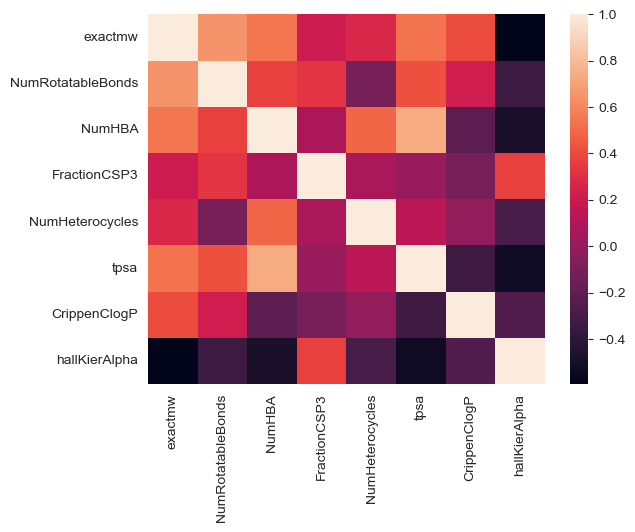

In [227]:
import seaborn as sns
unused_descriptors_names = ['NumSaturatedHeterocycles', 'NumAromaticRings', 'NumBridgeheadAtoms', 'NumHBD', 'NumSpiroAtoms',
                            'lipinskiHBD', 'NumAtomStereoCenters', 'NumAromaticHeterocycles', 'NumUnspecifiedAtomStereoCenters',
                            'NumAliphaticRings', 'NumAliphaticHeterocycles', 'NumRings', 'NumAmideBonds', 'NumSaturatedRings',
                            'lipinskiHBA', 'amw', 'chi0n', 'chi0v', 'chi1n', 'chi1v', 'chi2n', 'chi2v', 'chi3n', 'chi3v', 'chi4n', 'chi4v',
                            'kappa1', 'kappa2', 'kappa3', 'NumAtoms', 'NumHeavyAtoms', 'NumHeteroatoms', 'labuteASA', 'CrippenMR', 'Phi'
                                                    ]
corr = data[all_descriptor_names].drop(columns=unused_descriptors_names).corr()
sns.heatmap(corr)
corr

In [255]:
targets_1 = targets.loc[~targets['target_id'].isin(unused_targets)]
groups_by_target = data_scaled.drop(columns=unused_descriptors_names).groupby(by="target_id")
volumes = []

for target in targets_1['target_id']:
    describe = get_group(target).describe()
    val = describe.transpose()['75%'] - describe.transpose()['25%']
    volume = 1
    for i in val:
        volume *= i
    volumes.append(volume)

targets_volume = {'target_id':list(targets_1['target_id']), 'volume': volumes}
targets_volume = pd.DataFrame.from_dict(targets_volume)

In [263]:
targets_volume[targets_volume['volume'] == targets_volume.volume.max()]

,target_id,volume
244,P97266_WT,6.448877e-07
